# Twitter Trends/Tweets Archiver Development
Ryan Skinner, March 2019

## Objectives
This notebook serves as a playground for getting Twitter API calls working in Python, with the ultimate goal of archiving trends and tweets to an Amazon S3 bucket.

Specifically, we have four objectives:
1. Establish an authenticated connection with the Twitter API using oauth2
1. Query the Twitter/Trends API and select top-X trending hashtags in the US
1. Query the Twitter/Search API for each top-X trend to get relevant tweets in the US
1. Archive trends and tweets to S3

Once these objectives are achieved in this Jupyter Notebook, we'll package everything in a service that can be run in the background on an EC2 instance. [Many libraries exist for Twitter API calls in Python](https://developer.twitter.com/en/docs/developer-utilities/twitter-libraries.html), but we choose to use [Birdy](https://github.com/inueni/birdy) due to its simplicity.

## 1. Authenticate to Twitter API

We have created a Twitter developer account, as well as an app within that account. We wish to make calls to the Twitter API using [application-only authentication](https://developer.twitter.com/en/docs/basics/authentication/overview/application-only), since we do not wish to make calls that are associated with any specific user. Application calls also have a higher rate-limit on requests to the search/tweets endpoint.

Most of the following is automatically handled by [Birdy](https://github.com/inueni/birdy), but we describe the process in some detail for better understanding.

#### OAuth

Twitter has a nice explanation of the authentication flow at the above link, which follows these steps:

1. An application encodes its consumer key and secret key into a specially encoded set of credentials.
2. An application makes a request to the POST oauth2 / token endpoint to exchange these credentials for a bearer token.
3. When accessing the REST API, the application uses the bearer token to authenticate.

This [website has a nice overview of using OAuth in Python](https://requests-oauthlib.readthedocs.io/en/latest/oauth2_workflow.html#backend-application-flow).

#### Credentials as Environment Variables

All three credentials (the consumer key, secret key, and bearer token) give access to the Twitter API on behalf of the application, and should be considered as sensitive as passwords. **As such, we will store all three credentials as environment variables so they are not included in our code on GitHub.**

For testing purposes, we launch this Jupyter Notebook from `bash` with a modified environment with

>`env TWITTER_API_KEY=xxxxx TWITTER_API_KEY_SECRET=xxxxx jupyter notebook`

where the `xxxxx`'s are replaced with the values found on the Keys and Tokens tab of your application's page on https://developer.twitter.com/.

#### Transport Layer Security (TLS) Required

All requests to Twitter API endpoints, including to obtain and use tokens, [must use HTTPS endpoints](https://developer.twitter.com/en/docs/basics/authentication/guides/tls). Twitter advocates best practices for verifying certificates; see the aforementioned link.

#### Rate Limiting

A Twitter API exists that will return the [current status of rate-limiting for an application](https://developer.twitter.com/en/docs/developer-utilities/rate-limit-status/api-reference/get-application-rate_limit_status). Specifically, it will tell you the limit for each specified Twitter API endpoint, the number of requests remaining, and the duration in UNIX epoch seconds before the rate limit resets. See [documentation on fields returned by the rate_limit_status API here](https://developer.twitter.com/en/docs/basics/rate-limiting.html).

#### Start Coding!

Now that we have some preliminaries out of the way, let's start using Birdy to make requests.

In [114]:
import os
from birdy.twitter import AppClient

# Load consumer keys from environment variables.
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')

# Ensure API keys are present in environment variables.
print('Twitter API        key:', consumer_key)
print('Twitter API secret key:', consumer_secret)

Twitter API        key: cGOpUEJEL3bdO6I01DjXoj9Ar
Twitter API secret key: 96wRieT4BxELM94YsigyrFPR5V2g0muaZWYLRRQYOE5Int9mwt


With consumer keys loaded, let's set up authenticated requests.

In [115]:
# Initialize our client object with consumer keys.
client = AppClient(consumer_key, consumer_secret)

# Obtain the OAuth2 access token using our consumer keys.
access_token = client.get_access_token()

# Re-initialize our client object that stores the access token for later use.
client = AppClient(consumer_key, consumer_secret, access_token)

## 2. Hit Twitter's `trends/available` Endpoint

This endpoint returns the locations for which Twitter has trending topic information available.

In [116]:
resource_trends_available = client.api.trends.available

response_global = resource_trends_available.get()

In [117]:
print('Number of locations globally:', len(response_global.data))
response_global.data

Number of locations globally: 467


[{'name': 'Worldwide',
  'placeType': {'code': 19, 'name': 'Supername'},
  'url': 'http://where.yahooapis.com/v1/place/1',
  'parentid': 0,
  'country': '',
  'woeid': 1,
  'countryCode': None},
 {'name': 'Winnipeg',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2972',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 2972,
  'countryCode': 'CA'},
 {'name': 'Ottawa',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3369',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3369,
  'countryCode': 'CA'},
 {'name': 'Quebec',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3444',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3444,
  'countryCode': 'CA'},
 {'name': 'Montreal',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/3534',
  'parentid': 23424775,
  'country': 'Canada',
  'woeid': 3534,
  'co

There are currently 467 locations for which Twitter has trending topic information available.

In [118]:
response_usa = [x for x in response_global.data if x.country == 'United States']

print('Number of locations in USA:', len(response_usa))
response_usa

Number of locations in USA: 64


[{'name': 'Albuquerque',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2352824',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2352824,
  'countryCode': 'US'},
 {'name': 'Atlanta',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2357024',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2357024,
  'countryCode': 'US'},
 {'name': 'Austin',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2357536',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2357536,
  'countryCode': 'US'},
 {'name': 'Baltimore',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2358820',
  'parentid': 23424977,
  'country': 'United States',
  'woeid': 2358820,
  'countryCode': 'US'},
 {'name': 'Baton Rouge',
  'placeType': {'code': 7, 'name': 'Town'},
  'url': 'http://where.yahooapis.com/v1/place/2359

Of these 467 global locations, 64 are in the USA. Furthermore, we notice that all USA locations with trending hashtags available are cities, save for one entry which corresponds to the entire country.

Let's collect a list of all the `woeid`s corresponding to these USA-based locations.

In [119]:
woeids_usa = [x.woeid for x in response_usa]
woeids_usa

[2352824,
 2357024,
 2357536,
 2358820,
 2359991,
 2364559,
 2367105,
 2378426,
 2379574,
 2380358,
 2381475,
 2383489,
 2383660,
 2388929,
 2391279,
 2391585,
 2397816,
 2407517,
 2414469,
 2418046,
 2423945,
 2424766,
 2427032,
 2428184,
 2428344,
 2430683,
 2436704,
 2441472,
 2442047,
 2442327,
 2449323,
 2449808,
 2450022,
 2451822,
 2452078,
 2457170,
 2458410,
 2458833,
 2459115,
 2460389,
 2464592,
 2465512,
 2466256,
 2471217,
 2471390,
 2473224,
 2475687,
 2477058,
 2478307,
 2480894,
 2486340,
 2486982,
 2487610,
 2487796,
 2487889,
 2487956,
 2488042,
 2490383,
 2503713,
 2503863,
 2508428,
 2512636,
 2514815,
 23424977]

## 3. Hit Twitter's `trends/place` Endpoint

And now we hit Twitter's GET trends/place endpoint to obtain a list of trending hashtags for each USA-based `woeid` we just found.

This endpoint is limited to 75 requests per 15-minute window for both users and apps. Luckily, we have only 64 locations in the USA, so we should be able to hit each at a rate of once per 15 minutes. For development purposes, we'll start by hitting the endpoint for only San Fransisco.

In [120]:
woeid_test = 2487956 # San Fransisco

In [121]:
resource_trends_place = client.api.trends.place
response_test = resource_trends_place.get(id=woeid_test)

In [122]:
import json

print(json.dumps(response_test.data, indent=4))

[
    {
        "trends": [
            {
                "name": "Ajax",
                "url": "http://twitter.com/search?q=Ajax",
                "promoted_content": null,
                "query": "Ajax",
                "tweet_volume": 312726
            },
            {
                "name": "Real Madrid",
                "url": "http://twitter.com/search?q=%22Real+Madrid%22",
                "promoted_content": null,
                "query": "%22Real+Madrid%22",
                "tweet_volume": 185782
            },
            {
                "name": "#sweepstakes",
                "url": "http://twitter.com/search?q=%23sweepstakes",
                "promoted_content": null,
                "query": "%23sweepstakes",
                "tweet_volume": 27987
            },
            {
                "name": "#LoveKohls",
                "url": "http://twitter.com/search?q=%23LoveKohls",
                "promoted_content": null,
                "query": "%23LoveKohls",
        

In [123]:
trend_names = [x.name for x in response_test.data[0].trends]
trend_vols = [x.tweet_volume for x in response_test.data[0].trends]

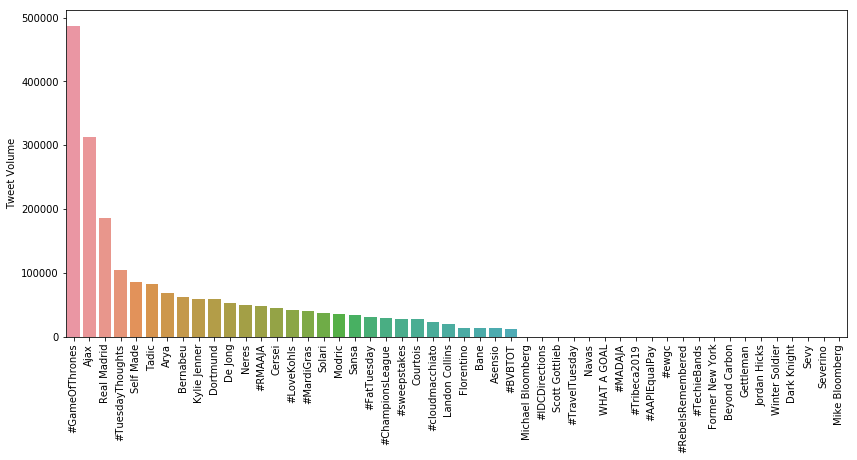

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

order = np.flip(np.argsort(np.nan_to_num(np.array(trend_vols, dtype=np.float))), axis=0)
trend_names = [trend_names[i] for i in order]
trend_vols = [trend_vols[i] for i in order]

plt.figure(figsize=[14,6])
sns.barplot(x=trend_names, y=trend_vols)
plt.ylabel('Tweet Volume')
plt.xticks(rotation='vertical')
plt.show()

Querying this endpoint during testing, it looks like the output can change  by a fairly large amount over the course of just one hour. This is why 15-minute resolution will likely be beneficial.